# Derivative 2D FHIT

In [30]:
import numpy as np
def derivative_2d_fhit(T, order, Tname):
    """
    Calculate spatial derivatives for 2D_FHIT
    Derivatives are calculated in spectral space
    Boundary conditions are periodic in x and y spatial dimensions
    Length of domain: 2*pi
    
    Args:
        T (ndarray): A 2D array of size M x N
        order (tuple): A tuple (orderX, orderY) specifying the order of the x and y derivatives, respectively
        Tname (str): A string representing the name of the input variable T
    
    Returns:
        ndarray: A 2D array containing the derivatives of T with respect to x and y
        str: A string representing the name of the output variable
    """
    orderX, orderY = order

    # Validating user input
    if orderX < 0 or orderY < 0:
        raise ValueError("Order of derivatives must be 0 or positive")
    elif orderX == 0 and orderY == 0:
        raise ValueError("Both order of derivatives are 0, at least one of them should be positive")

    Ngrid = T.shape
    Lx = 2 * np.pi  # Length of domain

    # Create wave numbers manually
    kx_pos = np.arange(0, Ngrid[0] / 2 + 1)
    kx_neg = np.arange(-Ngrid[0] / 2 + 1, 0)
    kx = np.concatenate((kx_pos, kx_neg)) * (2 * np.pi / Lx)
    
    # Making meshgrid
    Ky, Kx = np.meshgrid(kx, kx)
    
    ## This part needs to be checked 
    # Ngrid = T.shape
    # Lx = 2 * np.pi  # Length of domain
    
    # # Calculating the wave numbers
    # kx = 2 * np.pi * np.fft.fftfreq(Ngrid[0])
    # ky = 2 * np.pi * np.fft.fftfreq(Ngrid[1])

    # # Making meshgrid
    # Ky, Kx = np.meshgrid(ky, kx)



    # Calculating derivatives in spectral space
    T_hat = np.fft.fft2(T)
    Tdash_hat = ((1j * Kx) ** orderX) * ((1j * Ky) ** orderY) * T_hat
    Tdash = np.real(np.fft.ifft2(Tdash_hat))

    # Naming the variable
    TnameOut = Tname + ''.join(['x' * orderX, 'y' * orderY])

    return Tdash, TnameOut


# Contour Function

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.ticker as ticker
def create_contour_plot(data):
    """
    Creates a contour plot of a 2D matrix
    
    Args:
        data (numpy.ndarray): A 2D array of size M x N
    """
    # Create a contour plot with a blue-white-red colorbar
    fig, ax = plt.subplots()

    # Set font properties
    font = FontProperties()
    # font.set_family('Times New Roman')
    font.set_size(14)

    # Create a contour plot
    contour_levels = 1000
    contour_plot = ax.contourf(data, cmap='bwr', levels=contour_levels)
    plt.rcParams["text.usetex"] = True

    # Set nice tick locations for the colorbar
    ticks = ticker.MaxNLocator(nbins=5).tick_values(data.min(), data.max())

    # Add a colorbar to the plot
    colorbar = plt.colorbar(contour_plot, ticks=ticks)

    # Set title and axis labels
    ax.set_title("Contour Plot", fontproperties=font)
    ax.set_xlabel("$X-axis$", fontproperties=font)
    ax.set_ylabel("$Y-axis$", fontproperties=font)
    ax.set_facecolor((0, 0, 0, 0))  # Set alpha value of the face color to 0

    # Show the plot
    plt.show()

# Energy Transfer

In [33]:
import numpy as np

def energy_transfer_2d_fhit(U, V, Tau11, Tau12, Tau22):
    """
    Energy transfer of 2D_FHIT using SGS stress.
    Input is single snapshot (N x N matrix).
    
    Input:
    U, V: Velocities
    Tau11, Tau12, Tau22: SGS stress
    
    Output:
    PTau: energy transfer
    """
    
    Ux, _ = derivative_2d_fhit(U, (1,0), 'U')
    Uy, _ = derivative_2d_fhit(U, (0, 1), 'U')
    Vx, _ = derivative_2d_fhit(V, (1, 0), 'V')
    
    PTau = -(Tau11 - Tau22) * Ux - Tau12 * (Uy + Vx)
    
    return PTau


# CC Energy Transfer 2D-FHIT

In [34]:
import numpy as np

def cc_energy_transfer_2d_fhit(U, V, Tau11FDNS, Tau12FDNS, Tau22FDNS, Tau11Model, Tau12Model, Tau22Model):
    """
    Calculate the correlation coefficient (CC) of energy transfer between the truth (or filtered DNS data) and the model.
    
    Parameters
    ----------
    U, V : numpy.ndarray
        Velocities (NxN matrices).
    Tau11FDNS, Tau12FDNS, Tau22FDNS : numpy.ndarray
        SGS stress of the truth or filtered DNS data (NxN matrices).
    Tau11Model, Tau12Model, Tau22Model : numpy.ndarray
        SGS stress of the model (NxN matrices).

    Returns
    -------
    CCPTau : float
        CC between energy transfer of truth and model.
    CCPTauPos : float
        CC between energy transfer of grid points where P_FDNS > 0 (Positive - diffusion/forward scatter).
    CCPTauNeg : float
        CC between energy transfer of grid points where P_FDNS < 0 (Negative - backscatter).
    """
    
    PTauFDNS = energy_transfer_2d_fhit(U, V, Tau11FDNS, Tau12FDNS, Tau22FDNS)
    PTauModel = energy_transfer_2d_fhit(U, V, Tau11Model, Tau12Model, Tau22Model)

    CCPTau = np.corrcoef(PTauFDNS.ravel(), PTauModel.ravel())[0, 1]
    CCPTauPos = np.corrcoef(PTauFDNS[PTauFDNS > 0], PTauModel[PTauFDNS > 0])[0, 1]
    CCPTauNeg = np.corrcoef(PTauFDNS[PTauFDNS < 0], PTauModel[PTauFDNS < 0])[0, 1]
    
    return CCPTau, CCPTauPos, CCPTauNeg

In [5]:
import torch

def corr2(x, y, batch_mode=False):
    """
    Calculate the mean correlation coefficient between single or batches of input data.
    
    Parameters
    ----------
    x, y : torch.Tensor
        Input tensors with the same number of matrices and the same batch size if batch_mode is True 
        (dimensions should be (N, H, W) or (N, 1, H, W) for single and batch input).
    batch_mode : bool, optional
        Set True to calculate the correlation coefficient for batches of input data, by default False.
        
    Returns
    -------
    mean_corr_coeffs : float or torch.Tensor
        Mean correlation coefficient between the matrices in x and y for single input (float) 
        or mean correlation coefficients for each batch if batch_mode is True (torch.Tensor with shape: (B,)).
    """
    if not (isinstance(x, torch.Tensor) and isinstance(y, torch.Tensor)):
        raise ValueError("Both input tensors must be torch.Tensor objects.")
    
    if x.shape != y.shape:
        raise ValueError("Both input tensors must have the same dimensions.")
    
    # Remove singleton dimensions, if present
    x = torch.squeeze(x, dim=-3) if len(x.shape) == 4 else x
    y = torch.squeeze(y, dim=-3) if len(y.shape) == 4 else y

    if batch_mode:
        batch_size = x.shape[0]
        mean_corr_coeffs = torch.empty(batch_size, dtype=torch.float32)

        for batch_idx in range(batch_size):
            x_batch = x[batch_idx]
            y_batch = y[batch_idx]
            mean_corr_coeffs[batch_idx] = corr2(x_batch, y_batch)

        return mean_corr_coeffs

    else:
        x_mean_centered = x - x.mean(dim=(-2, -1)).reshape(-1, 1, 1)
        y_mean_centered = y - y.mean(dim=(-2, -1)).reshape(-1, 1, 1)

        r = (x_mean_centered * y_mean_centered).sum(dim=(-2, -1)) / torch.sqrt((x_mean_centered**2).sum(dim=(-2, -1)) * (y_mean_centered**2).sum(dim=(-2, -1)))
        mean_corr_coeff = r.mean().item()

        return mean_corr_coeff


In [36]:

def post_proccess(U, V, Tau11FDNS, Tau12FDNS, Tau22FDNS, Tau11Model, Tau12Model, Tau22Model):
    """
    Perform post-processing on input data and return calculated means and standard deviations for CC values.

    Args:
        U: A 3D array of U values.
        V: A 3D array of V values.
        Tau11FDNS, Tau12FDNS, Tau22FDNS: 3D arrays of FDNS tau values.
        Tau11Model, Tau12Model, Tau22Model: 3D arrays of model tau values.

    Returns:
        output: A dictionary containing the mean and standard deviation of calculated CC values.
    """
    data_size = U.shape[0]

    # Initialize variables
    CCTau11 = np.zeros(data_size)
    CCTau12 = np.zeros(data_size)
    CCTau22 = np.zeros(data_size)
    CCPTau = np.zeros(data_size)
    CCPTauPos = np.zeros(data_size)
    CCPTauNeg = np.zeros(data_size)

    for i in range(data_size):
        # Calculate the CC for tau11, tau12, tau22 (3 numbers)
        CCTau11[i] = corr2(Tau11Model[i], Tau11FDNS[i])
        CCTau12[i] = corr2(Tau12Model[i], Tau12FDNS[i])
        CCTau22[i] = corr2(Tau22Model[i], Tau22FDNS[i])

        # Calculate CC(PTau>0) & CC(PTau<0) (2 numbers)
        CCPTau[i], CCPTauPos[i], CCPTauNeg[i] = cc_energy_transfer_2d_fhit(U[i], V[i], 
                                                                           Tau11FDNS[i], Tau12FDNS[i],Tau22FDNS[i],
                                                                            Tau11Model[i], Tau12Model[i],Tau22Model[i])

    # Calculate the MEAN and STD for calculated CCs
    output = {
        'CCTau11': (np.mean(CCTau11), np.std(CCTau11)),
        'CCTau12': (np.mean(CCTau12), np.std(CCTau12)),
        'CCTau22': (np.mean(CCTau22), np.std(CCTau22)),
        'CCPTau': (np.mean(CCPTau), np.std(CCPTau)),
        'CCPTauPos': (np.mean(CCPTauPos), np.std(CCPTauPos)),
        'CCPTauNeg': (np.mean(CCPTauNeg), np.std(CCPTauNeg))
    }

    return output



In [40]:
output = post_proccess(u[0:15], v[0:15], tau11[0:15], tau12[0:15], tau22[0:15], tau11[0:15],tau12[15:30], tau22[15:30])
output["CCTau11"][0]


1.0

In [39]:
a = torch.rand(100,2,32,32)
print(a[:,0].shape)

torch.Size([100, 32, 32])


# Angular average

In [40]:
import numpy as np

def spectrum_angled_average_2D_FHIT(U):
    """
    Angled averaged spectrum for 2D flow variables
    Input: 2D Square matrix
    Output: 1D array
    """

    sizeU = U.shape

    if len(sizeU) != 2:
        raise ValueError("Input flow variable is not 2D. Please input a 2D matrix.")
    if sizeU[0] != sizeU[1]:
        raise ValueError("Dimension mismatch for flow variable. Flow variable should be a square matrix.")

    NX = len(U)
    Lx = 2 * np.pi  # Length of domain
    # Create wave numbers manually
    kx_pos = np.arange(0, sizeU[0] / 2 + 1)
    kx_neg = np.arange(-sizeU[0] / 2 + 1, 0)
    kx = np.concatenate((kx_pos, kx_neg)) * (2 * np.pi / Lx)

    Ky, Kx = np.meshgrid(kx, kx)
    Ksq = Kx ** 2 + Ky ** 2
    invKsq = 1.0 / Ksq
    invKsq[0, 0] = 0
    Kabs = np.sqrt(Ksq)

    # Removing mean
    U = U - np.mean(U)

    Ehat = np.fft.fft2(U)

    # Angle averaged energy spectrum
    arr_len = int(0.5 * np.sqrt((NX * NX + NX * NX)))
    n = arr_len + 1
    kplot = np.linspace(2, n, n)

    eplot = np.zeros(n)

    es = np.pi * (np.abs(Ehat)) / Kabs

    for k in range(1, n):
        eplot[k] = 0
        ic = 0
        for i in range(1, NX):
            for j in range(1, NX):
                kk = np.sqrt(kx[i] ** 2 + kx[j] ** 2)
                if (kk >= (k - 0.5) and kk < (k + 0.5)):
                    ic += 1
                    eplot[k] += es[i, j]

    tke = np.mean(eplot)
    TKE = tke / (NX ** 2)

    return TKE


# Importing Data

In [6]:
import h5py

path_uv = '/media/volume/sdb/data/2D_FHIT/Re20kNX1024nx4ny0r0p1/gaussian/train/NX128/UV.mat' 
path_s = '/media/volume/sdb/data/2D_FHIT/Re20kNX1024nx4ny0r0p1/gaussian/train/NX128/S.mat'

with h5py.File(path_uv,'r') as f:
    u = np.array(f['U'])
    v = np.array(f['V'])
    

with h5py.File(path_s,'r') as f:
    tau11 = np.array(f['S1'])
    tau12 = np.array(f['S2'])
    tau22 = np.array(f['S3'])


In [7]:
u = np.transpose(u, axes=(0,2,1))
v = np.transpose(v, axes=(0,2,1))
tau11 = np.transpose(tau11, axes=(0,2,1))
tau12 = np.transpose(tau12, axes=(0,2,1))
tau22 = np.transpose(tau22, axes=(0,2,1))


In [8]:
import torch
u = torch.from_numpy(u)
v = torch.from_numpy(v)
tau11 = torch.from_numpy(tau11)
tau12 = torch.from_numpy(tau12)
tau22 = torch.from_numpy(tau22)

# Test

In [10]:
# a = spectrum_angled_average_2D_FHIT(u[0])
print(u.shape[0])

10000


In [33]:
Ptau = energy_transfer_2d_fhit(u[0], v[0], tau11[0], tau12[0], tau22[0] )


In [27]:
cc = corr2(u[0:144], v[0:144])
print(cc)

0.008426445825017302


<built-in method type of Tensor object at 0x7fe995c93790>


In [28]:

CCPTau, CCPTauPos, CCPTauNeg = cc_energy_transfer_2d_fhit(u[0], v[0], tau11[0], tau12[0], tau22[0], tau22[1],tau12[1], tau11[1])
print(CCPTau)
print(CCPTauPos)
print(CCPTauNeg)


0.041454027909619016
0.07345207396334055
0.009042561602471738


In [29]:
d,_ = derivative_2d_fhit(u[0], (0,1), 'U')
# d_torch,_ = derivative_2d_fhit_torch(u[0], (0,1),'U')


In [30]:
print(d)


[[-2.62088038 -2.71165362 -2.72370552 ... -2.10125135 -2.32942469
  -2.53992638]
 [-2.72629379 -2.83247058 -2.91040034 ... -2.35631266 -2.47929298
  -2.59599085]
 [-2.93638329 -3.04486861 -3.09285032 ... -2.41775871 -2.60557021
  -2.79599137]
 ...
 [-1.96367236 -2.06404483 -2.17570467 ... -1.69103742 -1.66902394
  -1.78633258]
 [-2.04276399 -2.19711989 -2.42934906 ... -1.53704166 -1.69653777
  -1.83890789]
 [-2.41627349 -2.60299138 -2.71310799 ... -1.64076318 -1.89166576
  -2.16357551]]


Locator attempting to generate 1002 ticks ([-11.075000000000001, ..., 13.950000000000001]), which exceeds Locator.MAXTICKS (1000).


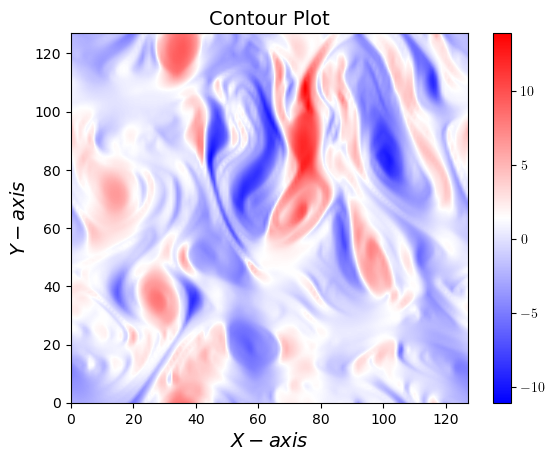

In [16]:
if __name__ == '__main__':
    create_contour_plot(d)

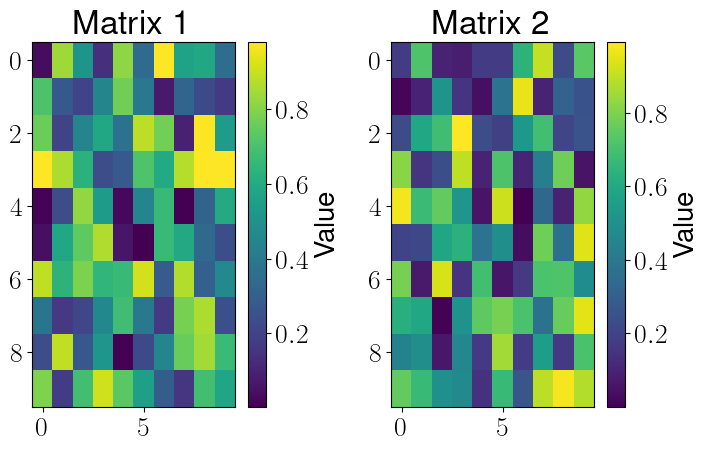

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def plot_2d_matrix(matrix1, matrix2):
    plt.rcParams.update({
        "text.usetex": True,
        "font.size": 20,
        "font.family": "Helvetica",
        "lines.markersize": 8,
        "lines.linewidth": 3
    })

    fig, axes = plt.subplots(1, 2, figsize=(19 / 2.54, 12.5 / 2.54))

    im1 = axes[0].imshow(matrix1, cmap='viridis', aspect='auto')
    axes[0].set_title("Matrix 1")
    fig.colorbar(im1, ax=axes[0], label="Value")

    im2 = axes[1].imshow(matrix2, cmap='viridis', aspect='auto')
    axes[1].set_title("Matrix 2")
    fig.colorbar(im2, ax=axes[1], label="Value")

    plt.tight_layout()
    plt.show()

# Example usage
matrix1 = np.random.rand(10, 10)
matrix2 = np.random.rand(10, 10)
plot_2d_matrix(matrix1, matrix2)
